# Generative Adversarial Networks (GANs)

So far in CS231N, all the applications of neural networks that we have explored have been **discriminative models** that take an input and are trained to produce a labeled output. This has ranged from straightforward classification of image categories to sentence generation (which was still phrased as a classification problem, our labels were in vocabulary space and we’d learned a recurrence to capture multi-word labels). In this notebook, we will expand our repetoire, and build **generative models** using neural networks. Specifically, we will learn how to build models which generate novel images that resemble a set of training images.

### What is a GAN?

In 2014, [Goodfellow et al.](https://arxiv.org/abs/1406.2661) presented a method for training generative models called Generative Adversarial Networks (GANs for short). In a GAN, we build two different neural networks. Our first network is a traditional classification network, called the **discriminator**. We will train the discriminator to take images, and classify them as being real (belonging to the training set) or fake (not present in the training set). Our other network, called the **generator**, will take random noise as input and transform it using a neural network to produce images. The goal of the generator is to fool the discriminator into thinking the images it produced are real.

We can think of this back and forth process of the generator ($G$) trying to fool the discriminator ($D$), and the discriminator trying to correctly classify real vs. fake as a minimax game:
$$\underset{G}{\text{minimize}}\; \underset{D}{\text{maximize}}\; \mathbb{E}_{x \sim p_\text{data}}\left[\log D(x)\right] + \mathbb{E}_{z \sim p(z)}\left[\log \left(1-D(G(z))\right)\right]$$
where $x \sim p_\text{data}$ are samples from the input data, $z \sim p(z)$ are the random noise samples, $G(z)$ are the generated images using the neural network generator $G$, and $D$ is the output of the discriminator, specifying the probability of an input being real. In [Goodfellow et al.](https://arxiv.org/abs/1406.2661), they analyze this minimax game and show how it relates to minimizing the Jensen-Shannon divergence between the training data distribution and the generated samples from $G$.

To optimize this minimax game, we will aternate between taking gradient *descent* steps on the objective for $G$, and gradient *ascent* steps on the objective for $D$:
1. update the **generator** ($G$) to minimize the probability of the __discriminator making the correct choice__. 
2. update the **discriminator** ($D$) to maximize the probability of the __discriminator making the correct choice__.

While these updates are useful for analysis, they do not perform well in practice. Instead, we will use a different objective when we update the generator: maximize the probability of the **discriminator making the incorrect choice**. This small change helps to allevaiate problems with the generator gradient vanishing when the discriminator is confident. This is the standard update used in most GAN papers, and was used in the original paper from [Goodfellow et al.](https://arxiv.org/abs/1406.2661). 

In this assignment, we will alternate the following updates:
1. Update the generator ($G$) to maximize the probability of the discriminator making the incorrect choice on generated data:
$$\underset{G}{\text{maximize}}\;  \mathbb{E}_{z \sim p(z)}\left[\log D(G(z))\right]$$
2. Update the discriminator ($D$), to maximize the probability of the discriminator making the correct choice on real and generated data:
$$\underset{D}{\text{maximize}}\; \mathbb{E}_{x \sim p_\text{data}}\left[\log D(x)\right] + \mathbb{E}_{z \sim p(z)}\left[\log \left(1-D(G(z))\right)\right]$$

### What else is there?
Since 2014, GANs have exploded into a huge research area, with massive [workshops](https://sites.google.com/site/nips2016adversarial/), and [hundreds of new papers](https://github.com/hindupuravinash/the-gan-zoo). Compared to other approaches for generative models, they often produce the highest quality samples but are some of the most difficult and finicky models to train (see [this github repo](https://github.com/soumith/ganhacks) that contains a set of 17 hacks that are useful for getting models working). Improving the stabiilty and robustness of GAN training is an open research question, with new papers coming out every day! For a more recent tutorial on GANs, see [here](https://arxiv.org/abs/1701.00160). There is also some even more recent exciting work that changes the objective function to Wasserstein distance and yields much more stable results across model architectures: [WGAN](https://arxiv.org/abs/1701.07875), [WGAN-GP](https://arxiv.org/abs/1704.00028).


GANs are not the only way to train a generative model! For other approaches to generative modeling check out the [deep generative model chapter](http://www.deeplearningbook.org/contents/generative_models.html) of the Deep Learning [book](http://www.deeplearningbook.org). Another popular way of training neural networks as generative models is Variational Autoencoders (co-discovered [here](https://arxiv.org/abs/1312.6114) and [here](https://arxiv.org/abs/1401.4082)). Variational autoencoders combine neural networks with variational inference to train deep generative models. These models tend to be far more stable and easier to train but currently don't produce samples that are as pretty as GANs.

Example pictures of what you should expect (yours might look slightly different):

![caption](gan_outputs_tf.png)


## Setup

In [1]:
from __future__ import print_function, division
import tensorflow as tf
import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# A bunch of utility functions

def show_images(images):
    images = np.reshape(images, [images.shape[0], -1])  # images reshape to (batch_size, D)
    sqrtn = int(np.ceil(np.sqrt(images.shape[0])))
    sqrtimg = int(np.ceil(np.sqrt(images.shape[1])))

    fig = plt.figure(figsize=(sqrtn, sqrtn))
    gs = gridspec.GridSpec(sqrtn, sqrtn)
    gs.update(wspace=0.05, hspace=0.05)

    for i, img in enumerate(images):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(img.reshape([sqrtimg,sqrtimg]))
    return

def preprocess_img(x):
    return 2 * x - 1.0

def deprocess_img(x):
    return (x + 1.0) / 2.0

def rel_error(x,y):
    return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

def count_params():
    """Count the number of parameters in the current TensorFlow graph """
    param_count = np.sum([np.prod(x.get_shape().as_list()) for x in tf.global_variables()])
    return param_count


def get_session():
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    session = tf.Session(config=config)
    return session

answers = np.load('gan-checks-tf.npz')

## Dataset
 GANs are notoriously finicky with hyperparameters, and also require many training epochs. In order to make this assignment approachable without a GPU, we will be working on the MNIST dataset, which is 60,000 training and 10,000 test images. Each picture contains a centered image of white digit on black background (0 through 9). This was one of the first datasets used to train convolutional neural networks and it is fairly easy -- a standard CNN model can easily exceed 99% accuracy. 

To simplify our code here, we will use the TensorFlow MNIST wrapper, which downloads and loads the MNIST dataset. See the [documentation](https://github.com/tensorflow/tensorflow/blob/master/tensorflow/contrib/learn/python/learn/datasets/mnist.py) for more information about the interface. The default parameters will take 5,000 of the training examples and place them into a validation dataset. The data will be saved into a folder called `MNIST_data`. 

**Heads-up**: The TensorFlow MNIST wrapper returns images as vectors. That is, they're size (batch, 784). If you want to treat them as images, we have to resize them to (batch,28,28) or (batch,28,28,1). They are also type np.float32 and bounded [0,1]. 

Extracting ./cs231n/datasets/MNIST_data/train-images-idx3-ubyte.gz
Extracting ./cs231n/datasets/MNIST_data/train-labels-idx1-ubyte.gz
Extracting ./cs231n/datasets/MNIST_data/t10k-images-idx3-ubyte.gz
Extracting ./cs231n/datasets/MNIST_data/t10k-labels-idx1-ubyte.gz


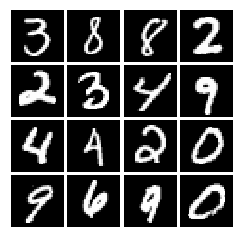

In [2]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('./cs231n/datasets/MNIST_data', one_hot=False)

# show a batch
show_images(mnist.train.next_batch(16)[0])

## LeakyReLU
In the cell below, you should implement a LeakyReLU. See the [class notes](http://cs231n.github.io/neural-networks-1/) (where alpha is small number) or equation (3) in [this paper](http://ai.stanford.edu/~amaas/papers/relu_hybrid_icml2013_final.pdf). LeakyReLUs keep ReLU units from dying and are often used in GAN methods (as are maxout units, however those increase model size and therefore are not used in this notebook).

HINT: You should be able to use `tf.maximum`

In [3]:
def leaky_relu(x, alpha=0.01):
    """Compute the leaky ReLU activation function.
    
    Inputs:
    - x: TensorFlow Tensor with arbitrary shape
    - alpha: leak parameter for leaky ReLU
    
    Returns:
    TensorFlow Tensor with the same shape as x
    """
    # return tf.minimum(x, 0)*alpha*x + tf.maximum(x, 0)*x
    return tf.cast(tf.less(x, 0),x.dtype)*alpha*x + tf.cast(tf.greater_equal(x, 0),x.dtype)*x
    

Test your leaky ReLU implementation. You should get errors < 1e-10

In [4]:
def test_leaky_relu(x, y_true):
    tf.reset_default_graph()
    with get_session() as sess:
        y_tf = leaky_relu(tf.constant(x))
        y = sess.run(y_tf)
        print('Maximum error: %1.1e'%rel_error(y_true, y))

test_leaky_relu(answers['lrelu_x'], answers['lrelu_y'])

Maximum error: 0.0e+00


## Random Noise
Generate a TensorFlow `Tensor` containing uniform noise from -1 to 1 with shape `[batch_size, dim]`.

In [5]:
def sample_noise(batch_size, dim):
    """Generate random uniform noise from -1 to 1.
    
    Inputs:
    - batch_size: integer giving the batch size of noise to generate
    - dim: integer giving the dimension of the the noise to generate
    
    Returns:
    TensorFlow Tensor containing uniform noise in [-1, 1] with shape [batch_size, dim]
    """
    
    return tf.random_uniform((batch_size, dim),minval=-1, maxval=1)

Make sure noise is the correct shape and type:

In [6]:
def test_sample_noise():
    batch_size = 3
    dim = 4
    tf.reset_default_graph()
    with get_session() as sess:
        z = sample_noise(batch_size, dim)
        # Check z has the correct shape
        assert z.get_shape().as_list() == [batch_size, dim]
        # Make sure z is a Tensor and not a numpy array
        assert isinstance(z, tf.Tensor)
        # Check that we get different noise for different evaluations
        z1 = sess.run(z)
        z2 = sess.run(z)
        assert not np.array_equal(z1, z2)
        # Check that we get the correct range
        assert np.all(z1 >= -1.0) and np.all(z1 <= 1.0)
        print("All tests passed!")
    
test_sample_noise()

All tests passed!


## Discriminator
Our first step is to build a discriminator. You should use the layers in `tf.layers` to build the model.
All fully connected layers should include bias terms.

Architecture:
 * Fully connected layer from size 784 to 256
 * LeakyReLU with alpha 0.01
 * Fully connected layer from 256 to 256
 * LeakyReLU with alpha 0.01
 * Fully connected layer from 256 to 1
 
The output of the discriminator should have shape `[batch_size, 1]`, and contain real numbers corresponding to the scores that each of the `batch_size` inputs is a real image.

In [7]:
def discriminator(x):
    """Compute discriminator score for a batch of input images.
    
    Inputs:
    - x: TensorFlow Tensor of flattened input images, shape [batch_size, 784]
    
    Returns:
    TensorFlow Tensor with shape [batch_size, 1], containing the score 
    for an image being real for each input image.
    """
    with tf.variable_scope("discriminator"):
        l1 = tf.layers.dense(inputs=x, units=256, activation=leaky_relu)
        l2 = tf.layers.dense(inputs=l1, units=256, activation=leaky_relu)
        logits = tf.layers.dense(inputs=l1, units=1, activation=None)
        
        return logits

Test to make sure the number of parameters in the discriminator is correct:

In [8]:
def test_discriminator(true_count=267009):
    tf.reset_default_graph()
    with get_session() as sess:
        y = discriminator(tf.ones((2, 784)))
        cur_count = count_params()
        if cur_count != true_count:
            print('Incorrect number of parameters in discriminator. {0} instead of {1}. Check your achitecture.'.format(cur_count,true_count))
        else:
            print('Correct number of parameters in discriminator.')
        
test_discriminator()

Correct number of parameters in discriminator.


## Generator
Now to build a generator. You should use the layers in `tf.layers` to construct the model. All fully connected layers should include bias terms.

Architecture:
 * Fully connected layer from tf.shape(z)[1] (the number of noise dimensions) to 1024
 * ReLU
 * Fully connected layer from 1024 to 1024 
 * ReLU
 * Fully connected layer from 1024 to 784
 * TanH (To restrict the output to be [-1,1])

In [9]:
def generator(z):
    """Generate images from a random noise vector.
    
    Inputs:
    - z: TensorFlow Tensor of random noise with shape [batch_size, noise_dim]
    
    Returns:
    TensorFlow Tensor of generated images, with shape [batch_size, 784].
    """
    with tf.variable_scope("generator"):
        l1 = tf.layers.dense(inputs=z, units=1024, activation=tf.nn.relu)
        l2 = tf.layers.dense(inputs=l1, units=1024, activation=tf.nn.relu)
        img = tf.layers.dense(inputs=l1, units=784, activation=tf.nn.tanh)
        
        return img

Test to make sure the number of parameters in the generator is correct:

In [10]:
def test_generator(true_count=1858320):
    tf.reset_default_graph()
    with get_session() as sess:
        y = generator(tf.ones((1, 4)))
        cur_count = count_params()
        if cur_count != true_count:
            print('Incorrect number of parameters in generator. {0} instead of {1}. Check your achitecture.'.format(cur_count,true_count))
        else:
            print('Correct number of parameters in generator.')
        
test_generator()

Correct number of parameters in generator.


# GAN Loss

Compute the generator and discriminator loss. The generator loss is:
$$\ell_G  =  -\mathbb{E}_{z \sim p(z)}\left[\log D(G(z))\right]$$
and the discriminator loss is:
$$ \ell_D = -\mathbb{E}_{x \sim p_\text{data}}\left[\log D(x)\right] - \mathbb{E}_{z \sim p(z)}\left[\log \left(1-D(G(z))\right)\right]$$
Note that these are negated from the equations presented earlier as we will be *minimizing* these losses.

**HINTS**: Use [tf.ones_like](https://www.tensorflow.org/api_docs/python/tf/ones_like) and [tf.zeros_like](https://www.tensorflow.org/api_docs/python/tf/zeros_like) to generate labels for your discriminator. Use [sigmoid_cross_entropy loss](https://www.tensorflow.org/api_docs/python/tf/nn/sigmoid_cross_entropy_with_logits) to help compute your loss function. Instead of computing the expectation, we will be averaging over elements of the minibatch, so make sure to combine the loss by averaging instead of summing.

In [11]:
def gan_loss(logits_real, logits_fake):
    """Compute the GAN loss.
    
    Inputs:
    - logits_real: Tensor, shape [batch_size, 1], output of discriminator
        Log probability that the image is real for each real image
    - logits_fake: Tensor, shape[batch_size, 1], output of discriminator
        Log probability that the image is real for each fake image
    
    Returns:
    - D_loss: discriminator loss scalar
    - G_loss: generator loss scalar
    """
    
    # REMEMBER 
    # x~p_data = samples from the input data
    # z~p(z) = random noise samples
    # G(z) = generated images using the generator 
    # D = output of the discriminator, specifying the probability of an input being real
    # TODO: compute D_loss and G_loss
    
    D_fake = tf.nn.sigmoid_cross_entropy_with_logits(logits = logits_fake, labels=tf.zeros_like(logits_fake))
    D_real = tf.nn.sigmoid_cross_entropy_with_logits(logits = logits_real, labels=tf.ones_like(logits_real))
    G = tf.nn.sigmoid_cross_entropy_with_logits(logits = logits_fake, labels=tf.ones_like(logits_fake))
    
    D_loss = tf.reduce_mean(D_real) + tf.reduce_mean(D_fake)
    G_loss = tf.reduce_mean(G)
    
    return D_loss, G_loss

Test your GAN loss. Make sure both the generator and discriminator loss are correct. You should see errors less than 1e-5.

In [12]:
def test_gan_loss(logits_real, logits_fake, d_loss_true, g_loss_true):
    tf.reset_default_graph()
    with get_session() as sess:
        d_loss, g_loss = sess.run(gan_loss(tf.constant(logits_real), tf.constant(logits_fake)))
    print("Maximum error in d_loss: %1.15e"%rel_error(d_loss_true, d_loss))
    print("Maximum error in g_loss: %1.15e"%rel_error(g_loss_true, g_loss)) 

test_gan_loss(answers['logits_real'], answers['logits_fake'],
              answers['d_loss_true'], answers['g_loss_true'])

Maximum error in d_loss: 0.000000000000000e+00
Maximum error in g_loss: 0.000000000000000e+00


# Optimizing our loss
Make an `AdamOptimizer` with a 1e-3 learning rate, beta1=0.5 to mininize G_loss and D_loss separately. The trick of decreasing beta was shown to be effective in helping GANs converge in the [Improved Techniques for Training GANs](https://arxiv.org/abs/1606.03498) paper. In fact, with our current hyperparameters, if you set beta1 to the Tensorflow default of 0.9, there's a good chance your discriminator loss will go to zero and the generator will fail to learn entirely. In fact, this is a common failure mode in GANs; if your D(x) learns to be too fast (e.g. loss goes near zero), your G(z) is never able to learn. Often D(x) is trained with SGD with Momentum or RMSProp instead of Adam, but here we'll use Adam for both D(x) and G(z). 

In [13]:
# TODO: create an AdamOptimizer for D_solver and G_solver
def get_solvers(learning_rate=1e-3, beta1=0.5):
    """Create solvers for GAN training.
    
    Inputs:
    - learning_rate: learning rate to use for both solvers
    - beta1: beta1 parameter for both solvers (first moment decay)
    
    Returns:
    - D_solver: instance of tf.train.AdamOptimizer with correct learning_rate and beta1
    - G_solver: instance of tf.train.AdamOptimizer with correct learning_rate and beta1
    """
    D_solver = tf.train.AdamOptimizer(learning_rate = learning_rate, beta1 = beta1)
    G_solver = tf.train.AdamOptimizer(learning_rate = learning_rate, beta1 = beta1)

    return D_solver, G_solver

## Putting it all together
Now just a bit of Lego Construction.. Read this section over carefully to understand how we'll be composing the generator and discriminator

In [14]:
tf.reset_default_graph()

# number of images for each batch
batch_size = 128
# our noise dimension
noise_dim = 96

# placeholder for images from the training dataset
x = tf.placeholder(tf.float32, [None, 784])
# random noise fed into our generator
z = sample_noise(batch_size, noise_dim)
# generated images
G_sample = generator(z)

with tf.variable_scope("") as scope:
    #scale images to be -1 to 1
    logits_real = discriminator(preprocess_img(x))
    # Re-use discriminator weights on new inputs
    scope.reuse_variables()
    logits_fake = discriminator(G_sample)

# Get the list of variables for the discriminator and generator
D_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, 'discriminator')
G_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, 'generator') 

# get our solver
D_solver, G_solver = get_solvers()

# get our loss
D_loss, G_loss = gan_loss(logits_real, logits_fake)

# setup training steps
D_train_step = D_solver.minimize(D_loss, var_list=D_vars)
G_train_step = G_solver.minimize(G_loss, var_list=G_vars)
D_extra_step = tf.get_collection(tf.GraphKeys.UPDATE_OPS, 'discriminator')
G_extra_step = tf.get_collection(tf.GraphKeys.UPDATE_OPS, 'generator')

# Training a GAN!
Well that wasn't so hard, was it? In the iterations in the low 100s you should see black backgrounds, fuzzy shapes as you approach iteration 1000, and decent shapes, about half of which will be sharp and clearly recognizable as we pass 3000. In our case, we'll simply train D(x) and G(z) with one batch each every iteration. However, papers often experiment with different schedules of training D(x) and G(z), sometimes doing one for more steps than the other, or even training each one until the loss gets "good enough" and then switching to training the other. 

In [15]:
# a giant helper function
def run_a_gan(sess, G_train_step, G_loss, D_train_step, D_loss, G_extra_step, D_extra_step,\
              show_every=250, print_every=50, batch_size=128, num_epoch=10):
    """Train a GAN for a certain number of epochs.
    
    Inputs:
    - sess: A tf.Session that we want to use to run our data
    - G_train_step: A training step for the Generator
    - G_loss: Generator loss
    - D_train_step: A training step for the Generator
    - D_loss: Discriminator loss
    - G_extra_step: A collection of tf.GraphKeys.UPDATE_OPS for generator
    - D_extra_step: A collection of tf.GraphKeys.UPDATE_OPS for discriminator
    Returns:
        Nothing
    """
    # compute the number of iterations we need
    max_iter = int(mnist.train.num_examples*num_epoch/batch_size)
    for it in range(max_iter):
        # every show often, show a sample result
        if it % show_every == 0:
            samples = sess.run(G_sample)
            fig = show_images(samples[:16])
            plt.show()
            print()
        # run a batch of data through the network
        minibatch,minbatch_y = mnist.train.next_batch(batch_size)
        _, D_loss_curr = sess.run([D_train_step, D_loss], feed_dict={x: minibatch})
        _, G_loss_curr = sess.run([G_train_step, G_loss])

        # print loss every so often.
        # We want to make sure D_loss doesn't go to 0
        if it % print_every == 0:
            print('Iter: {}, D: {:.4}, G:{:.4}'.format(it,D_loss_curr,G_loss_curr))
    print('Final images')
    samples = sess.run(G_sample)

    fig = show_images(samples[:16])
    plt.show()

#### Train your GAN! This should take about 10 minutes on a CPU, or less than a minute on GPU.

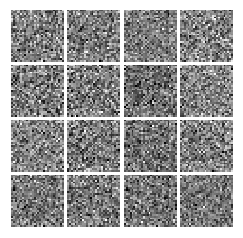


Iter: 0, D: 2.167, G:0.8672
Iter: 50, D: 0.5222, G:3.354
Iter: 100, D: 0.5978, G:1.179
Iter: 150, D: 1.133, G:0.6308
Iter: 200, D: 1.021, G:1.433


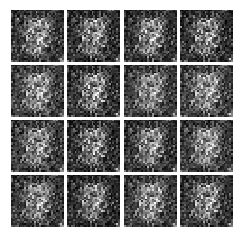


Iter: 250, D: 0.7908, G:1.3
Iter: 300, D: 0.7682, G:1.294
Iter: 350, D: 0.576, G:3.516
Iter: 400, D: 0.846, G:1.433
Iter: 450, D: 0.931, G:1.577


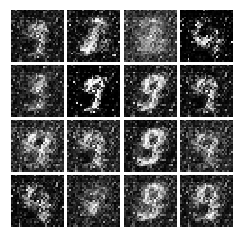


Iter: 500, D: 1.155, G:1.909
Iter: 550, D: 1.125, G:1.96
Iter: 600, D: 1.167, G:0.8288
Iter: 650, D: 1.101, G:0.8319
Iter: 700, D: 1.09, G:1.21


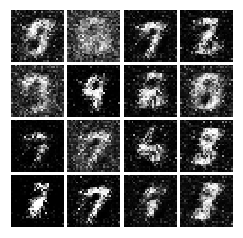


Iter: 750, D: 1.014, G:1.134
Iter: 800, D: 0.7707, G:2.416
Iter: 850, D: 1.003, G:1.024
Iter: 900, D: 0.8256, G:2.035
Iter: 950, D: 0.9614, G:1.396


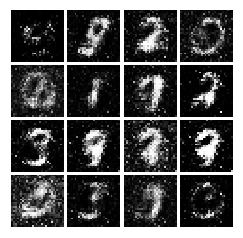


Iter: 1000, D: 0.9713, G:1.253
Iter: 1050, D: 1.172, G:1.54
Iter: 1100, D: 1.088, G:0.9822
Iter: 1150, D: 1.214, G:1.18
Iter: 1200, D: 1.3, G:2.285


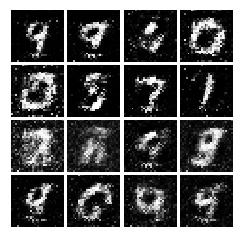


Iter: 1250, D: 1.05, G:1.063
Iter: 1300, D: 1.028, G:2.155
Iter: 1350, D: 0.9738, G:1.374
Iter: 1400, D: 1.135, G:1.11
Iter: 1450, D: 1.187, G:1.713


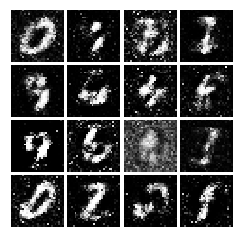


Iter: 1500, D: 1.204, G:1.268
Iter: 1550, D: 1.107, G:1.148
Iter: 1600, D: 1.37, G:1.005
Iter: 1650, D: 1.347, G:0.877
Iter: 1700, D: 1.147, G:1.37


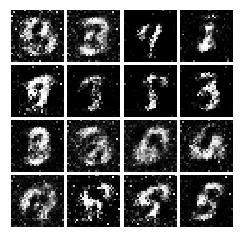


Iter: 1750, D: 1.249, G:1.619
Iter: 1800, D: 1.384, G:1.3
Iter: 1850, D: 1.25, G:0.9836
Iter: 1900, D: 1.253, G:1.046
Iter: 1950, D: 1.329, G:1.003


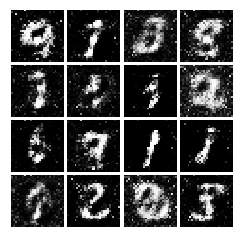


Iter: 2000, D: 1.218, G:0.9859
Iter: 2050, D: 1.229, G:1.013
Iter: 2100, D: 1.302, G:1.136
Iter: 2150, D: 1.243, G:0.9589
Iter: 2200, D: 1.184, G:1.363


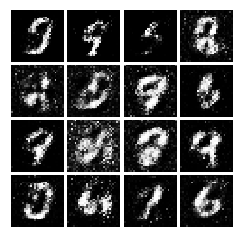


Iter: 2250, D: 1.309, G:0.9422
Iter: 2300, D: 1.273, G:0.8435
Iter: 2350, D: 1.18, G:0.8811
Iter: 2400, D: 1.333, G:0.8964
Iter: 2450, D: 1.365, G:1.005


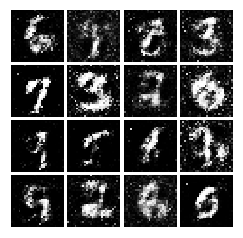


Iter: 2500, D: 1.258, G:1.356
Iter: 2550, D: 1.266, G:1.009
Iter: 2600, D: 1.254, G:0.666
Iter: 2650, D: 1.431, G:1.347
Iter: 2700, D: 1.175, G:1.384


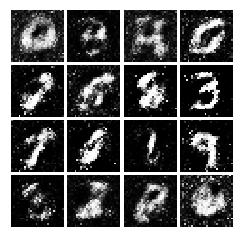


Iter: 2750, D: 1.193, G:1.183
Iter: 2800, D: 1.259, G:1.208
Iter: 2850, D: 1.169, G:1.222
Iter: 2900, D: 1.236, G:1.089
Iter: 2950, D: 1.247, G:1.036


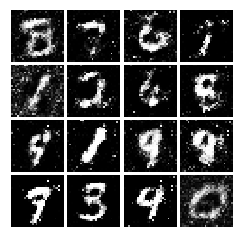


Iter: 3000, D: 1.2, G:0.9386
Iter: 3050, D: 1.274, G:1.123
Iter: 3100, D: 1.265, G:1.036
Iter: 3150, D: 1.277, G:0.9325
Iter: 3200, D: 1.351, G:0.7568


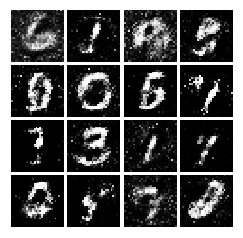


Iter: 3250, D: 1.193, G:1.048
Iter: 3300, D: 1.307, G:1.084
Iter: 3350, D: 1.317, G:0.9493
Iter: 3400, D: 1.319, G:0.8309
Iter: 3450, D: 1.203, G:0.9273


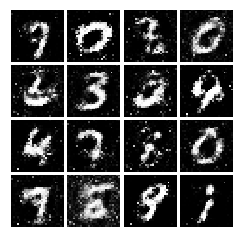


Iter: 3500, D: 1.442, G:0.3644
Iter: 3550, D: 1.293, G:0.8813
Iter: 3600, D: 1.298, G:1.044
Iter: 3650, D: 1.181, G:0.8632
Iter: 3700, D: 1.321, G:0.8257


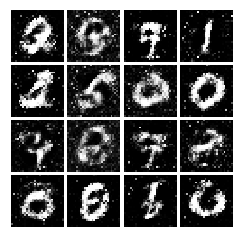


Iter: 3750, D: 1.271, G:0.937
Iter: 3800, D: 1.258, G:0.8714
Iter: 3850, D: 1.267, G:0.8472
Iter: 3900, D: 1.327, G:0.8575
Iter: 3950, D: 1.316, G:0.8204


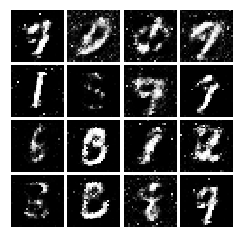


Iter: 4000, D: 1.17, G:1.229
Iter: 4050, D: 1.27, G:1.519
Iter: 4100, D: 1.295, G:1.36
Iter: 4150, D: 1.248, G:1.075
Iter: 4200, D: 1.325, G:0.7926


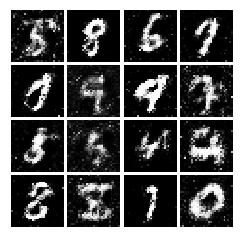


Iter: 4250, D: 1.343, G:0.8612
Final images


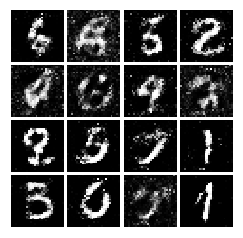

In [16]:
with get_session() as sess:
    sess.run(tf.global_variables_initializer())
    run_a_gan(sess,G_train_step,G_loss,D_train_step,D_loss,G_extra_step,D_extra_step)

# Least Squares GAN
We'll now look at [Least Squares GAN](https://arxiv.org/abs/1611.04076), a newer, more stable alternative to the original GAN loss function. For this part, all we have to do is change the loss function and retrain the model. We'll implement equation (9) in the paper, with the generator loss:
$$\ell_G  =  \frac{1}{2}\mathbb{E}_{z \sim p(z)}\left[\left(D(G(z))-1\right)^2\right]$$
and the discriminator loss:
$$ \ell_D = \frac{1}{2}\mathbb{E}_{x \sim p_\text{data}}\left[\left(D(x)-1\right)^2\right] + \frac{1}{2}\mathbb{E}_{z \sim p(z)}\left[ \left(D(G(z))\right)^2\right]$$


**HINTS**: Instead of computing the expectation, we will be averaging over elements of the minibatch, so make sure to combine the loss by averaging instead of summing. When plugging in for $D(x)$ and $D(G(z))$ use the direct output from the discriminator (`score_real` and `score_fake`).

In [17]:
def lsgan_loss(score_real, score_fake):
    """Compute the Least Squares GAN loss.
    
    Inputs:
    - score_real: Tensor, shape [batch_size, 1], output of discriminator
        score for each real image
    - score_fake: Tensor, shape[batch_size, 1], output of discriminator
        score for each fake image    
          
    Returns:
    - D_loss: discriminator loss scalar
    - G_loss: generator loss scalar
    """

    D_fake = .5*tf.losses.mean_squared_error(tf.zeros_like(score_fake),score_fake )
    D_real = .5*tf.losses.mean_squared_error(tf.ones_like(score_real),score_real)
    G = .5*tf.losses.mean_squared_error(tf.ones_like(score_fake),score_fake)
    
    D_loss = D_fake + D_real
    G_loss = G
    
    return D_loss, G_loss

Test your LSGAN loss. You should see errors less than 1e-7.

In [18]:
def test_lsgan_loss(score_real, score_fake, d_loss_true, g_loss_true):
    with get_session() as sess:
        d_loss, g_loss = sess.run(
            lsgan_loss(tf.constant(score_real), tf.constant(score_fake)))
    print("Maximum error in d_loss: %1.15e"%rel_error(d_loss_true, d_loss))
    print("Maximum error in g_loss: %1.15e"%rel_error(g_loss_true, g_loss))
    
test_lsgan_loss(answers['logits_real'], answers['logits_fake'],
                answers['d_loss_lsgan_true'], answers['g_loss_lsgan_true'])

Maximum error in d_loss: 1.643768572306838e-08
Maximum error in g_loss: 3.369607324416479e-08


Create new training steps so we instead minimize the LSGAN loss:

In [19]:
D_loss, G_loss = lsgan_loss(logits_real, logits_fake)
D_train_step = D_solver.minimize(D_loss, var_list=D_vars)
G_train_step = G_solver.minimize(G_loss, var_list=G_vars)

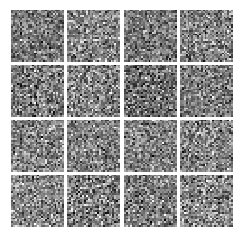


Iter: 0, D: 1.436, G:0.4357
Iter: 50, D: 0.07165, G:1.888
Iter: 100, D: 0.04179, G:1.031
Iter: 150, D: 0.03869, G:1.346
Iter: 200, D: 0.0339, G:0.8542


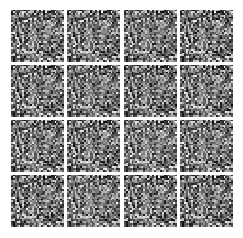


Iter: 250, D: 0.03056, G:0.5637
Iter: 300, D: 0.09107, G:1.035
Iter: 350, D: 0.02776, G:0.6693
Iter: 400, D: 0.03632, G:0.7462
Iter: 450, D: 0.06346, G:0.304


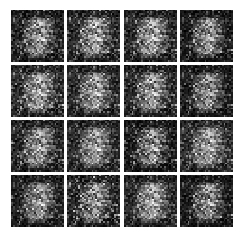


Iter: 500, D: 0.09684, G:0.3343
Iter: 550, D: 0.07189, G:0.291
Iter: 600, D: 0.05732, G:0.3554
Iter: 650, D: 0.0456, G:0.3943
Iter: 700, D: 0.36, G:0.5624


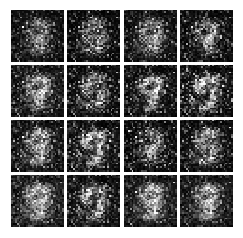


Iter: 750, D: 0.06289, G:0.3625
Iter: 800, D: 0.07562, G:0.4233
Iter: 850, D: 0.1088, G:0.2868
Iter: 900, D: 0.121, G:0.2162
Iter: 950, D: 0.09387, G:0.2691


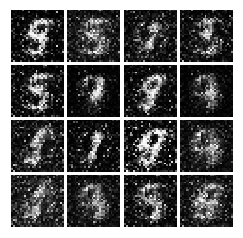


Iter: 1000, D: 0.1107, G:0.4192
Iter: 1050, D: 0.1446, G:0.2784
Iter: 1100, D: 0.1126, G:0.3287
Iter: 1150, D: 0.106, G:0.291
Iter: 1200, D: 0.1107, G:0.28


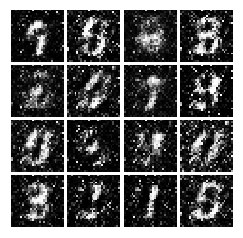


Iter: 1250, D: 0.1213, G:0.3144
Iter: 1300, D: 0.1243, G:0.3713
Iter: 1350, D: 0.1191, G:0.2838
Iter: 1400, D: 0.132, G:0.3787
Iter: 1450, D: 0.1166, G:0.3483


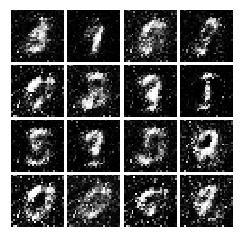


Iter: 1500, D: 0.1379, G:0.2931
Iter: 1550, D: 0.1415, G:0.3274
Iter: 1600, D: 0.149, G:0.3007
Iter: 1650, D: 0.1627, G:0.301
Iter: 1700, D: 0.1536, G:0.2642


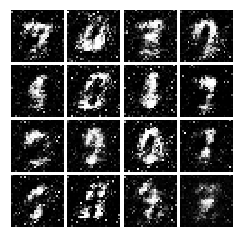


Iter: 1750, D: 0.1709, G:0.1601
Iter: 1800, D: 0.1683, G:0.2494
Iter: 1850, D: 0.2431, G:0.06541
Iter: 1900, D: 0.1485, G:0.3469
Iter: 1950, D: 0.2022, G:0.123


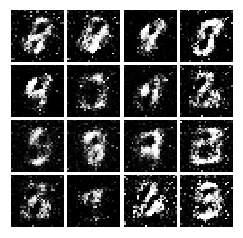


Iter: 2000, D: 0.1477, G:0.2342
Iter: 2050, D: 0.1547, G:0.2447
Iter: 2100, D: 0.1378, G:0.3552
Iter: 2150, D: 0.1512, G:0.2288
Iter: 2200, D: 0.1563, G:0.2677


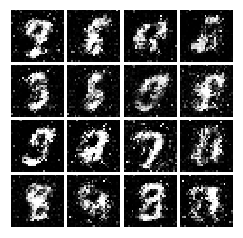


Iter: 2250, D: 0.1417, G:0.2745
Iter: 2300, D: 0.1484, G:0.2946
Iter: 2350, D: 0.1514, G:0.2828
Iter: 2400, D: 0.1569, G:0.3337
Iter: 2450, D: 0.166, G:0.2164


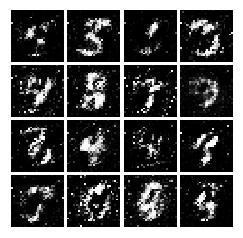


Iter: 2500, D: 0.1778, G:0.2163
Iter: 2550, D: 0.1422, G:0.2845
Iter: 2600, D: 0.167, G:0.3109
Iter: 2650, D: 0.1575, G:0.2601
Iter: 2700, D: 0.1655, G:0.2821


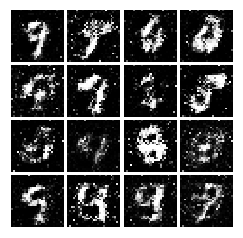


Iter: 2750, D: 0.1714, G:0.2212
Iter: 2800, D: 0.159, G:0.2558
Iter: 2850, D: 0.1706, G:0.223
Iter: 2900, D: 0.168, G:0.2496
Iter: 2950, D: 0.1718, G:0.201


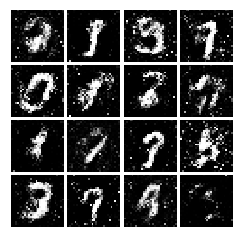


Iter: 3000, D: 0.1793, G:0.238
Iter: 3050, D: 0.1656, G:0.2635
Iter: 3100, D: 0.1577, G:0.2511
Iter: 3150, D: 0.1827, G:0.2058
Iter: 3200, D: 0.1802, G:0.2459


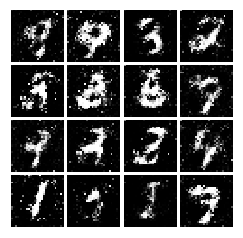


Iter: 3250, D: 0.1831, G:0.2664
Iter: 3300, D: 0.1854, G:0.2112
Iter: 3350, D: 0.173, G:0.2215
Iter: 3400, D: 0.1708, G:0.2107
Iter: 3450, D: 0.1794, G:0.231


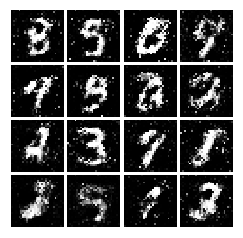


Iter: 3500, D: 0.1725, G:0.2378
Iter: 3550, D: 0.177, G:0.2185
Iter: 3600, D: 0.1716, G:0.2216
Iter: 3650, D: 0.1817, G:0.2301
Iter: 3700, D: 0.1685, G:0.1994


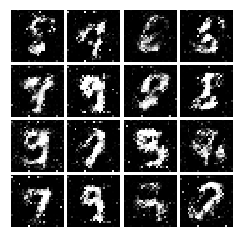


Iter: 3750, D: 0.1846, G:0.2358
Iter: 3800, D: 0.1774, G:0.2397
Iter: 3850, D: 0.1838, G:0.2334
Iter: 3900, D: 0.1746, G:0.1785
Iter: 3950, D: 0.1856, G:0.2206


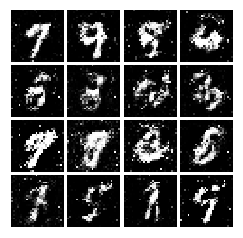


Iter: 4000, D: 0.1887, G:0.2164
Iter: 4050, D: 0.1859, G:0.2457
Iter: 4100, D: 0.2016, G:0.2221
Iter: 4150, D: 0.1851, G:0.1921
Iter: 4200, D: 0.1725, G:0.2256


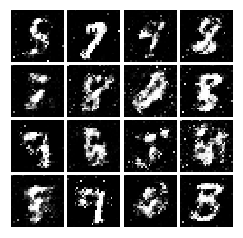


Iter: 4250, D: 0.2025, G:0.2029
Final images


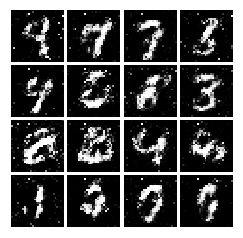

In [20]:
with get_session() as sess:
    sess.run(tf.global_variables_initializer())
    run_a_gan(sess, G_train_step, G_loss, D_train_step, D_loss, G_extra_step, D_extra_step)

# INLINE QUESTION 1:
Describe how the visual quality of the samples changes over the course of training. Do you notice anything about the distribution of the samples? How do the results change across different training runs?

The shape of the digits gets better at every run, but the digits themselves seem to be changing at each iteration.

# Deep Convolutional GANs
In the first part of the notebook, we implemented an almost direct copy of the original GAN network from Ian Goodfellow. However, this network architecture allows no real spatial reasoning. It is unable to reason about things like "sharp edges" in general because it lacks any convolutional layers. Thus, in this section, we will implement some of the ideas from [DCGAN](https://arxiv.org/abs/1511.06434), where we use convolutional networks as our discriminators and generators.

#### Discriminator
We will use a discriminator inspired by the TensorFlow MNIST classification [tutorial](https://www.tensorflow.org/get_started/mnist/pros), which is able to get above 99% accuracy on the MNIST dataset fairly quickly. *Be sure to check the dimensions of x and reshape when needed*, fully connected blocks expect [N,D] Tensors while conv2d blocks expect [N,H,W,C] Tensors. 

Architecture:
* 32 Filters, 5x5, Stride 1, Leaky ReLU(alpha=0.01)
* Max Pool 2x2, Stride 2
* 64 Filters, 5x5, Stride 1, Leaky ReLU(alpha=0.01)
* Max Pool 2x2, Stride 2
* Flatten
* Fully Connected size 4 x 4 x 64, Leaky ReLU(alpha=0.01)
* Fully Connected size 1

**NOTE:**

DO **NOT** USE PADDING FOR THE DISCRIMINATOR, otherwise you'll get the wrong number of parameters. 

**DO** USE PADDING FOR THE GENERATOR, otherwise you'll get the wrong image size.

Note that TensorFlow does **NOT** use padding  by default. 

In [21]:
def discriminator(x):
    """Compute discriminator score for a batch of input images.
    
    Inputs:
    - x: TensorFlow Tensor of flattened input images, shape [batch_size, 784]
    
    Returns:
    TensorFlow Tensor with shape [batch_size, 1], containing the score 
    for an image being real for each input image.
    """

    X = tf.reshape(x,[-1,28,28,1])    


    hw0 = 28 # height = width of the input 

    # assuming we use the same parameters for each convolutional layer
    ck1 = 5 # window size - "k" like "kernel"
    p1 = 0 # padding 
    f1 = 32 # number of filters
    cs1 = 1 # stride (default TF = 1)

    # pooling
    pk1 = 2

    # heights = widths after the 1st CNN layer 
    hwc1 = math.floor((hw0 - ck1 + 2*p1)/cs1+1)

    # heights = widths after 1st maxpooling
    hwp1 = int(hwc1/pk1)

    ################################################
    # assuming we use the same parameters for each convolutional layer
    ck2 = 5 # window size - "k" like "kernel"
    p2 = 0 # padding 
    f2 = 64 # number of filters
    cs2 = 1 # stride (default TF = 1)

    # pooling
    pk2 = 2

    # heights = widths after the 2nd CNN layer 
    hwc2 = math.floor((hwp1 - ck2 + 2*p2)/cs2+1)

    # heights = widths after 2nd maxpooling
    hwp2 = int(hwc2/pk2)
 
    
    with tf.variable_scope("discriminator"):
       
        conv1 = tf.layers.conv2d(X, f1, ck1, padding="valid", activation=leaky_relu)
        pool1 = tf.layers.max_pooling2d(conv1,pk1,pk1) 

        conv2 = tf.layers.conv2d(pool1, f2, ck2, padding="valid", activation=leaky_relu)
        pool2 = tf.layers.max_pooling2d(conv2,pk2,pk2) 

        flat= tf.reshape(pool2, [-1, hwp2 * hwp2 * f2])
        
        d = tf.layers.dense(inputs=flat, units=4*4*64, activation=leaky_relu)
        
        logits = tf.layers.dense(inputs=d, units=1, activation=None)
        
        return logits
    
test_discriminator(1102721)

Correct number of parameters in discriminator.


#### Generator
For the generator, we will copy the architecture exactly from the [InfoGAN paper](https://arxiv.org/pdf/1606.03657.pdf). See Appendix C.1 MNIST. See the documentation for [tf.nn.conv2d_transpose](https://www.tensorflow.org/api_docs/python/tf/nn/conv2d_transpose). We are always "training" in GAN mode.

Architecture:
* Fully connected of size 1024, ReLU
* BatchNorm
* Fully connected of size 7 x 7 x 128, ReLU
* BatchNorm
* Resize into Image Tensor
* 64 conv2d^T (transpose) filters of 4x4, stride 2, ReLU
* BatchNorm
* 1 conv2d^T (transpose) filter of 4x4, stride 2, TanH

**NOTE:**

**DO** USE PADDING FOR THE GENERATOR, otherwise you'll get the wrong image size.

Note that TensorFlow does **NOT** use padding  by default. 

In [22]:
def generator(z):
    """Generate images from a random noise vector.
    
    Inputs:
    - z: TensorFlow Tensor of random noise with shape [batch_size, noise_dim]
    
    Returns:
    TensorFlow Tensor of generated images, with shape [batch_size, 784].
    """
    
    is_training = True

    with tf.variable_scope("generator"):
        
        l1 = tf.layers.dense(inputs=z, units=1024, activation=tf.nn.relu)
        bn1 = tf.layers.batch_normalization(l1,training = is_training)
        
        l2 = tf.layers.dense(inputs=bn1, units= 7*7*128, activation=tf.nn.relu)
        bn2 = tf.layers.batch_normalization(l2,training = is_training)        
        
        X = tf.reshape(bn2,[-1,7,7,128])    
        
        convT1 = tf.layers.conv2d_transpose (X, 64, 4, strides =(2,2), padding="same", activation=tf.nn.relu)

        bn2 = tf.layers.batch_normalization(convT1,training = is_training)          
        
        convT2 = tf.layers.conv2d_transpose (bn2, 1, 4, strides =(2,2), padding="same", activation=tf.nn.tanh)
        
        img = tf.reshape(convT2,[-1,784])    
        
        return img
    
test_generator(6595521)


Correct number of parameters in generator.


We have to recreate our network since we've changed our functions.

In [23]:
tf.reset_default_graph()

batch_size = 128
# our noise dimension
noise_dim = 96

# placeholders for images from the training dataset
x = tf.placeholder(tf.float32, [None, 784])
z = sample_noise(batch_size, noise_dim)
# generated images
G_sample = generator(z)

with tf.variable_scope("") as scope:
    #scale images to be -1 to 1
    logits_real = discriminator(preprocess_img(x))
    # Re-use discriminator weights on new inputs
    scope.reuse_variables()
    logits_fake = discriminator(G_sample)

# Get the list of variables for the discriminator and generator
D_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,'discriminator')
G_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,'generator') 

D_solver,G_solver = get_solvers()
D_loss, G_loss = gan_loss(logits_real, logits_fake)
D_train_step = D_solver.minimize(D_loss, var_list=D_vars)
G_train_step = G_solver.minimize(G_loss, var_list=G_vars)
D_extra_step = tf.get_collection(tf.GraphKeys.UPDATE_OPS,'discriminator')
G_extra_step = tf.get_collection(tf.GraphKeys.UPDATE_OPS,'generator')

### Train and evaluate a DCGAN
This is the one part of A3 that significantly benefits from using a GPU. It takes 3 minutes on a GPU for the requested five epochs. Or about 50 minutes on a dual core laptop on CPU (feel free to use 3 epochs if you do it on CPU).

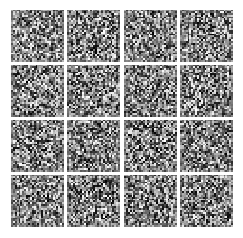


Iter: 0, D: 1.381, G:0.8862
Iter: 50, D: 0.6743, G:0.8743
Iter: 100, D: 0.8715, G:1.376
Iter: 150, D: 1.003, G:1.096
Iter: 200, D: 1.052, G:0.8655


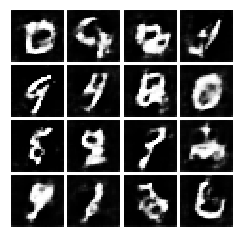


Iter: 250, D: 1.275, G:0.5401
Iter: 300, D: 1.412, G:0.2295
Iter: 350, D: 1.12, G:0.6918
Iter: 400, D: 1.355, G:2.113
Iter: 450, D: 1.113, G:0.8783


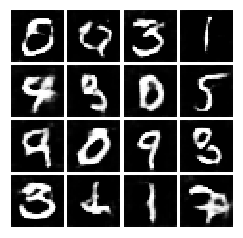


Iter: 500, D: 1.168, G:1.081
Iter: 550, D: 1.179, G:0.8927
Iter: 600, D: 1.101, G:0.8977
Iter: 650, D: 1.126, G:0.9206
Iter: 700, D: 1.17, G:1.011


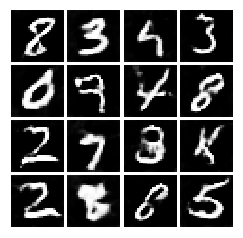


Iter: 750, D: 1.113, G:0.8922
Iter: 800, D: 1.186, G:1.134
Iter: 850, D: 1.518, G:2.008
Iter: 900, D: 1.154, G:0.7399
Iter: 950, D: 1.101, G:1.102


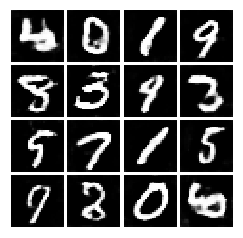


Iter: 1000, D: 1.257, G:0.8264
Iter: 1050, D: 1.309, G:1.226
Iter: 1100, D: 1.094, G:1.014
Iter: 1150, D: 1.11, G:0.9221
Iter: 1200, D: 1.09, G:0.9252


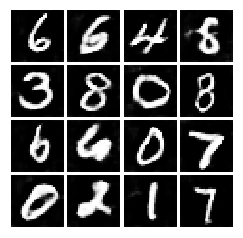


Iter: 1250, D: 1.137, G:0.8209
Iter: 1300, D: 1.091, G:1.003
Iter: 1350, D: 1.373, G:1.584
Iter: 1400, D: 1.071, G:0.8485
Iter: 1450, D: 1.078, G:0.8645


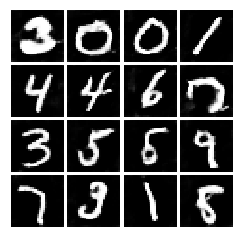


Iter: 1500, D: 1.04, G:0.7966
Iter: 1550, D: 1.057, G:1.044
Iter: 1600, D: 1.083, G:1.116
Iter: 1650, D: 1.076, G:1.036
Iter: 1700, D: 1.421, G:0.6694


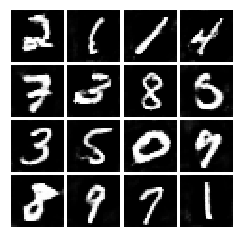


Iter: 1750, D: 1.094, G:0.927
Iter: 1800, D: 1.1, G:0.9887
Iter: 1850, D: 1.157, G:0.6634
Iter: 1900, D: 1.306, G:0.7128
Iter: 1950, D: 1.068, G:0.7895


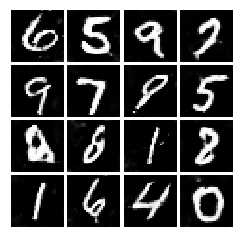


Iter: 2000, D: 1.043, G:0.8829
Iter: 2050, D: 1.133, G:1.279
Iter: 2100, D: 1.127, G:0.9161
Final images


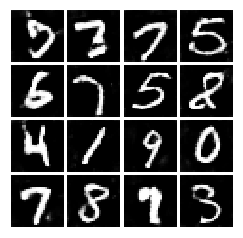

In [24]:
with get_session() as sess:
    sess.run(tf.global_variables_initializer())
    run_a_gan(sess,G_train_step,G_loss,D_train_step,D_loss,G_extra_step,D_extra_step,num_epoch=5)

# INLINE QUESTION 2:
What differences do you see between the DCGAN results and the original GAN results?

The results are much sharper, even after just one iteration.